In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.stats import norm
import scipy.stats

In [19]:
class env:
    def __init__(self,H,sigma,p_e,length,TickSize,LotSize,k):
        self.H = H
        self.sigma = sigma
        self.p_e = p_e
        self.length = length
        self.TickSize = TickSize
        self.LotSize = LotSize
        self.k = k
    
    def GeneratePath(self):
        #path generator
        #x_t = log(p_t/p_e)
        #dx_t = -lambda*x_t+sigma*w_t
        self._lambda = np.log(2)/self.H
        x_t = 0
        p_t = [50]
        count = 0
        for i in range(self.length):
            x_t+=-self._lambda*x_t+self.sigma*np.random.normal()
            #price generator
            if x_t>np.log(2):
                p_t.append(1000)
                #x_t = np.log(2)
                count+=1
            else:
                p_t.append(int(10*self.p_e*np.exp(x_t)))
        print(count)
        return p_t
    
    def SpreadCost(self,DeltaN):
        return self.TickSize*DeltaN
    
    def ImpactCost(self,DeltaN):
        return DeltaN**2*self.TickSize/self.LotSize
    
    def Reward(self,state1,state2):
        delta_v = state2[1]*(state2[0]-state1[0])*self.LotSize/10 \
        -self.SpreadCost(state2[1]-state1[1])-self.ImpactCost(state2[1]-state1[1])
        return delta_v-0.5*self.k*delta_v**2
        
        

In [20]:
ans = np.random.normal(size = 10**7)
scipy.stats.normaltest(ans)
scipy.stats.anderson(ans)
scipy.stats.kstest(ans,cdf='norm')

KstestResult(statistic=0.00032232646005880827, pvalue=0.24989764146958221)

In [21]:
class QLearningTable:
    def __init__(self, positions, learning_rate, reward_decay,epsilon_greedy,K,M,_env):
        self.positions = positions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.q_table = pd.DataFrame(columns=self.positions,index = range(1,1001))
        self.epsilon = epsilon_greedy
        self.K = K
        self.M = M
        self.env = _env
        self.fitted = False
        for i in range(1,1001):
            for j in self.positions:
                self.q_table.loc[i,j] = [0]*(2*self.K+1)
    
    def get_index(self,s):
        _ind = []
        _max = max(s)
        for i in range(0,len(s)):
            if s[i] == _max:
                _ind.append(i)
        return _ind
    
    def choose_action(self, state):
        #observation is a tuple
        # action selection
        if np.random.uniform() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[state[0], state[1]][self.K+max(-self.M,state[1]-self.K)\
                                                                -state[1]:self.K+1+min(self.M,state[1]+self.K)-state[1]]
            _ind = self.get_index(state_action)     # some actions have same value
            if len(_ind)>1:   
                np.random.shuffle(_ind)
            action = _ind[0]+self.K+max(-self.M,state[1]-self.K)-state[1]
        else:
            # choose random action
            action = np.random.choice(range(self.K+max(-self.M,state[1]-self.K)-state[1],\
                                            self.K+1+min(self.M,state[1]+self.K)-state[1]))
        return action

    def learn(self,s,a,s_):
        q_predict = self.q_table.loc[s[0], s[1]][a]
        q_target = self.env.Reward(s,s_) \
        + self.gamma * max(self.q_table.loc[s_[0],s_[1]][self.K+max(-self.M,s_[1]-self.K)\
                                                                -s_[1]:self.K+1+min(self.M,s_[1]+self.K)-s_[1]]) 
        self.q_table.loc[s[0], s[1]][a] += self.lr * (q_target - q_predict)  # update

            
    def fit(self,initial_point):
        self.fitted = True
        s = initial_point
        #self.q_table[:] = [0]*(2*self.K+1)
        price = self.env.GeneratePath()
        for i in range(1,len(price)):
            action = self.choose_action(s)
            s_ = (price[i],s[1]+action-self.K)
            self.learn(s,action,s_)
            s = s_
            if i%(10**5) == 0:
                print(i/(10**5))
    
    def q_table(self):
        assert self.fitted
        return self.q_table

In [22]:
class TestQtable:
    def __init__(self,env,q_table):
        self.env = env
        self.q_table = q_table
        self.profit = [0]
    
    def StepProfit(self,s,s_):
        delta_v = s_[1]*(s_[0]-s[0])*self.env.LotSize/10-self.env.SpreadCost(s_[1]-s[1])-self.env.ImpactCost(s_[1]-s[1])
        return delta_v
    
    def test(self,initial_point):
        price = self.env.GeneratePath()
        plt.plot(price)
        plt.show()
        s = initial_point
        for p in price[1:]:
            action = self.q_table.choose_action(s)
            s_ = (p,s[1]+action-self.q_table.K)
            self.profit.append(self.profit[-1]+ self.StepProfit(s,s_))
            s = s_
        
    def TotalProfit(self):
        return self.profit

In [23]:
env3 = env(5,0.1,50,10**5,.1,100,10**(-4))

In [24]:
pr = env3.GeneratePath()

7


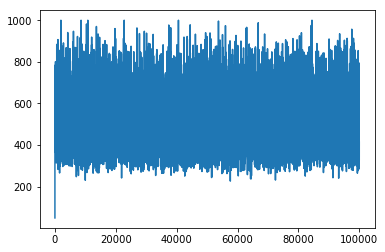

In [25]:
plt.plot(pr)
plt.show()

In [26]:
action = range(-10,11)
env1 = env(5,0.1,50,10**6,0.1,100,10**(-4))

In [27]:
model = QLearningTable(action,0.001,0.999,0.1,5,10,env1)

In [28]:
model.fit((500,0))

196
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


In [29]:
env2 = env(5,0.1,50,5000,0.1,100,10**(-4))

In [30]:
test = TestQtable(env2,model)

1


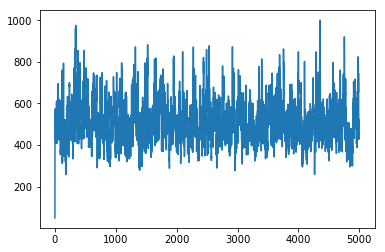

In [31]:
test.test((500,0))

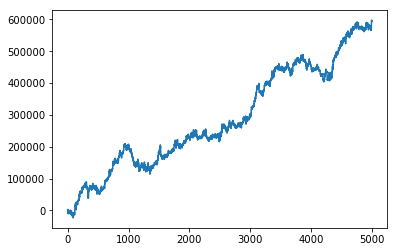

In [32]:
plt.plot(test.profit)
plt.show()